<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='../../pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
</div>
</a>

# Practicum Convolution Neural Nets (CNN) Deel 1

**Doel: Toepassen Convolutional Neural Networks**

### Imports

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T
from os import listdir, path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.io import ImageReadMode
from torchvision.io import read_image






<h3>Globale variabelen</h3>

In [22]:
forestDirectory = '../../pics/2750/Forest'
industrialDirectory = '../../pics/2750/Industrial'

In [99]:
# to show a single image in a dataset with its label shaped as either (3, 64, 64) or (1, 64, 64) tensor.

def ShowDatasetImage(dataset, index=0):
    # if index is random, pick a random index number
    if index == 'random':
        index = random.randint(0, len(dataset) - 1)

    # Access the image and label using indexing
    image, label = dataset[index]
    image, label = 1,1

    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image = np.transpose(image.numpy(), (1, 2, 0))

    # Normalize the pixel values to the range [0, 1]
    np_image = np_image / 255.0

    # Display the image using matplotlib
    plt.imshow(np_image)
    # Show the label and the shape of the tensor image
    image_shape = image.shape
    plt.title(f"Label: {label} - {image_shape}")
    plt.axis('off')
    plt.show()
    print(image)

In [70]:
# show a single image from the dataloader

def ShowDataloaderImage(dataloader):
    # Get the batch of images and labels from the dataloader
    images, labels = next(iter(dataloader))

    # Access the first image and label
    image, label = images[0], labels[0]

    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image = np.transpose(image.numpy(), (1, 2, 0))

    # Normalize the pixel values to the range [0, 1]
    np_image = np_image / 255.0

    # Display the image using matplotlib
    plt.imshow(np_image)
    # Show the label and the shape of the tensor image
    image_shape = image.shape
    plt.title(f"Label: {label} - {image_shape}")
    plt.axis('off')
    plt.show()
    print(image)






    

In [151]:
# to show an image from the dataloader with its label
def show_batch(train_d,test_d,val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_test = next(iter(test_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][0]
    image_test = data_test[0][0]
    image_val = data_val[0][0]
    label_train = data_train[1][0]
    label_test = data_test[1][0]
    label_val = data_val[1][0]
  

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3)


    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()
    

        # Display the original image in the first subplot
    axes[0].imshow(np_image_train)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the pooled image in the second subplot
    axes[1].imshow(np_image_test)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1].set_title(f'{label_test}, {image_test.shape}')

    # Display the pooled image in the third subplot
    axes[2].imshow(np_image_val)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[2].set_title(f'{label_val}, {image_val.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()

### Context

<p>
Dit practicum bestaat uit twee onderdelen
<ol>
    <li>Het toepassen van een convolutie en pooling filter</li>
    <li><b>Het bouwen en trainen van een eenvoudig convolutional neural net dat een industrieterrein van een bos kan onderscheiden.</b></li>
</ol>    
Voor beide oefeningen gebruiken we de EuroSAT_RGB dataset
</p>

<img src='../../pics/eurosat_cnn.png' length=65% width=65%>

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://github.com/phelber/EuroSAT">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=40% width=40%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

## Opdrachten

### Opdracht 3: pooling uitvoeren

Met PyTorch Functional kunnen we ook een pooling filter toepassen.

the image dtype = torch.float32, its shape = torch.Size([1, 64, 64])


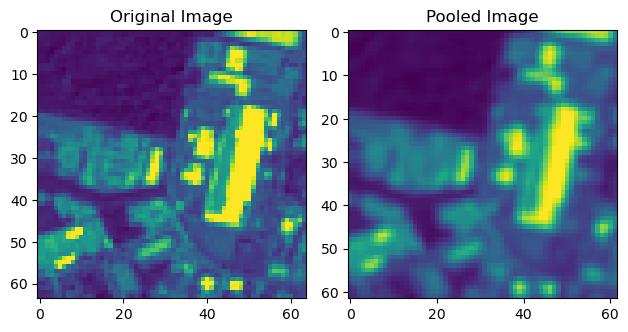

In [24]:
# a. Bekijk de pooling opties en kies de juiste avg-variant
#    - https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html


# b. Pas pooling toe op de afbeelding 'Industrial_1.jpg':
#    - Zet de afbeelding om naar een tensor
LOCATION = industrialDirectory
IMPORTPATH = f'{LOCATION}/Industrial_1.jpg'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')


#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=3, stride=1)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
industrial = np.squeeze(industrial)
industrialPooled = np.squeeze(industrialPooled)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the original image in the first subplot
axes[0].imshow(industrial)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0].set_title('Original Image')

# Display the pooled image in the second subplot
axes[1].imshow(industrialPooled)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1].set_title('Pooled Image')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()  

# c. Herhaal de bovenstaande stappen voor een willekeure Forest Image

the image dtype = torch.float32, its shape = torch.Size([1, 64, 64])


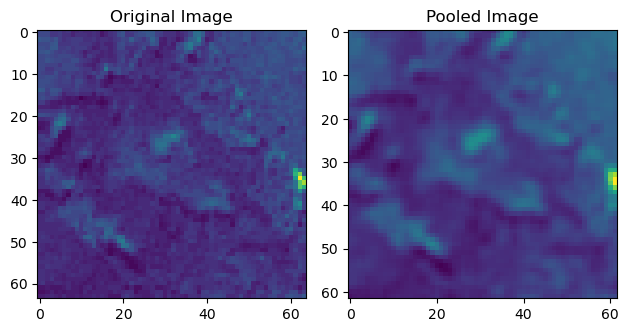

In [25]:
# a. Bekijk de pooling opties en kies de juiste avg-variant
#    - https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html


# b. Pas pooling toe op de afbeelding 'Industrial_1.jpg':
#    - Zet de afbeelding om naar een tensor
LOCATION = forestDirectory
IMPORTPATH = f'{LOCATION}/{random.choice(listdir(forestDirectory))}'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')


#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=3, stride=1)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
industrial = np.squeeze(industrial)
industrialPooled = np.squeeze(industrialPooled)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the original image in the first subplot
axes[0].imshow(industrial)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0].set_title('Original Image')

# Display the pooled image in the second subplot
axes[1].imshow(industrialPooled)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1].set_title('Pooled Image')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot



# c. Herhaal de bovenstaande stappen voor een willekeure Forest Image

### Reflectie

Komt de visuele uitkomst overeen met je verwachtingen?

the image dtype = torch.float32, its shape = torch.Size([1, 64, 64])


<module 'matplotlib.pyplot' from '/Users/stephandekker/miniconda3/envs/miw2/lib/python3.10/site-packages/matplotlib/pyplot.py'>

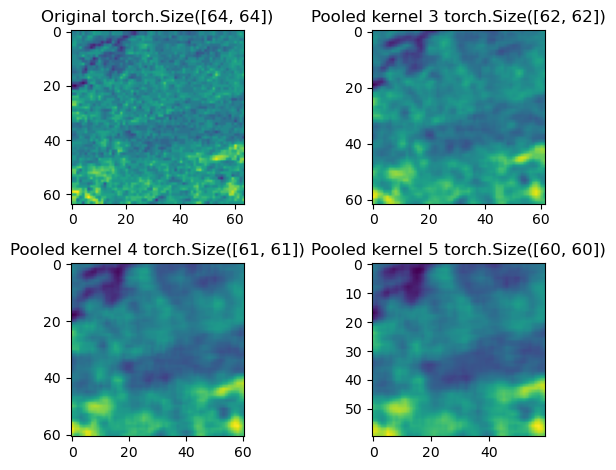

In [81]:
# door de kernel te vergroten wordt de afbeelding steeds grofkorreliger


# b. Pas pooling toe op de afbeelding 'Industrial_1.jpg':
#    - Zet de afbeelding om naar een tensor
LOCATION = forestDirectory
IMPORTPATH = f'{LOCATION}/{random.choice(listdir(forestDirectory))}'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')

kernel0 = 3
kernel1 = 4
kernel2 = 5

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=(kernel0), stride=1)(industrial)

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled1 = nn.AvgPool2d(kernel_size=(kernel1), stride=1)(industrial)

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled2 = nn.AvgPool2d(kernel_size=(kernel2), stride=1)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
img0 = np.squeeze(industrial)
img1 = np.squeeze(industrialPooled)
img2 = np.squeeze(industrialPooled1)
img3 = np.squeeze(industrialPooled2)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2)

# Display the original image in the first subplot
axes[0][0].imshow(img0)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][0].set_title(f'Original {img0.shape}')

# Display the pooled image in the second subplot
axes[0][1].imshow(img1)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][1].set_title(f'Pooled kernel {kernel0} {img1.shape}')

# Display the pooled image in the second subplot
axes[1][0].imshow(img2)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][0].set_title(f'Pooled kernel {kernel1} {img2.shape}')

# Display the pooled image in the second subplot
axes[1][1].imshow(img3)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][1].set_title(f'Pooled kernel {kernel2} {img3.shape}')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot
plt


### Reflectie

Wat is de invloed van padding en stride op de uitkomst?

the image dtype = torch.float32, its shape = torch.Size([1, 64, 64])


<module 'matplotlib.pyplot' from '/Users/stephandekker/miniconda3/envs/miw2/lib/python3.10/site-packages/matplotlib/pyplot.py'>

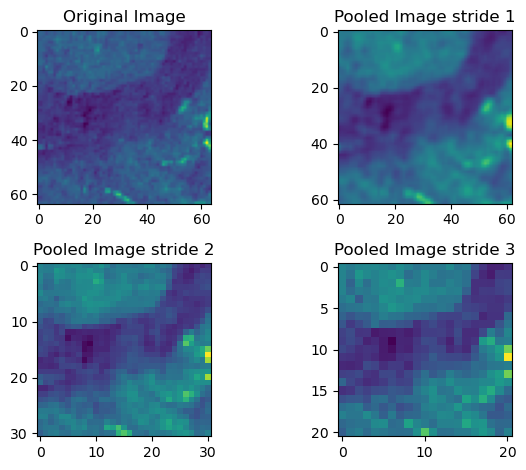

In [27]:
# door de kernel te vergroten wordt de afbeelding steeds grofkorreliger


# b. Pas pooling toe op de afbeelding 'Industrial_1.jpg':
#    - Zet de afbeelding om naar een tensor
LOCATION = forestDirectory
IMPORTPATH = f'{LOCATION}/{random.choice(listdir(forestDirectory))}'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')

kernel0 = 3
kernel1 = 3
kernel2 = 3

stride0 = 1
stride1 = 2
stride2 = 3


#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=(kernel0), stride=stride0)(industrial)

#    - Kies een 3x3 kernel en een stride van 2
industrialPooled1 = nn.AvgPool2d(kernel_size=(kernel1), stride=stride1)(industrial)

#    - Kies een 3x3 kernel en een stride van 3
industrialPooled2 = nn.AvgPool2d(kernel_size=(kernel2), stride=stride2)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
img0 = np.squeeze(industrial)
img1 = np.squeeze(industrialPooled)
img2 = np.squeeze(industrialPooled1)
img3 = np.squeeze(industrialPooled2)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2)

# Display the original image in the first subplot
axes[0][0].imshow(img0)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][0].set_title('Original Image')

# Display the pooled image in the second subplot
axes[0][1].imshow(img1)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][1].set_title(f'Pooled Image stride {stride0}')

# Display the pooled image in the second subplot
axes[1][0].imshow(img2)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][0].set_title(f'Pooled Image stride {stride1}')

# Display the pooled image in the second subplot
axes[1][1].imshow(img3)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][1].set_title(f'Pooled Image stride {stride2}')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot
plt.show


the image dtype = torch.float32, its shape = torch.Size([1, 64, 64])
tensor(61.)

tensor(60.)
tensor(58.1541)
tensor(58.1315)
tensor(56.9415)
tensor(55.9809)


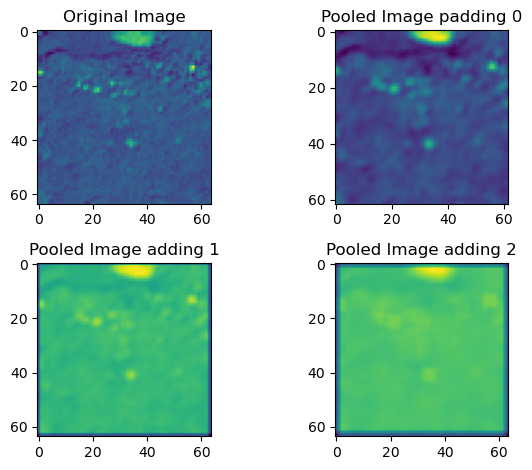

In [28]:
# when adding the padding it should be at most half the kernel size
# bij het plotten van de afbeeldingen gebeurt er iets geks, de grijswaardes in het midden van de afbeelding worden lichter afgebeeld doordat de buitenrand zo extreen donker is. 


#    - Zet de afbeelding om naar een tensor
LOCATION = forestDirectory
IMPORTPATH = f'{LOCATION}/{random.choice(listdir(forestDirectory))}'
industrial = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the image dtype = {industrial.dtype}, its shape = {industrial.shape}')

kernel0 = 3
kernel1 = 3
kernel2 = 5

stride0 = 1
stride1 = 1
stride2 = 1

padding0 = 0
padding1 = 1
padding2 = 2


#    - Kies een 3x3 kernel en een stride van 1
industrialPooled = nn.AvgPool2d(kernel_size=(kernel0), stride=stride0, padding=padding0)(industrial)

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled1 = nn.AvgPool2d(kernel_size=(kernel1), stride=stride1, padding=padding1)(industrial)

#    - Kies een 3x3 kernel en een stride van 1
industrialPooled2 = nn.AvgPool2d(kernel_size=(kernel2), stride=stride2, padding=padding2)(industrial)

#    - Plot de afbeelding en de ge-poolde afbeelding    

# Set the savefig.bbox parameter to 'tight'
plt.rcParams["savefig.bbox"] = 'tight'


# Remove single-dimensional entries from the shape of the tensors
img0 = np.squeeze(industrial)
img1 = np.squeeze(industrialPooled)
img2 = np.squeeze(industrialPooled1)
img3 = np.squeeze(industrialPooled2)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2)
print(img0[32][32])
print()
print(img1[32][32])
# Display the original image in the first subplot
axes[0][0].imshow(img0)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][0].set_title('Original Image')

# Display the pooled image in the second subplot
axes[0][1].imshow(img1)  # ,cmap='gray' after the image name to create a greyscale image.
axes[0][1].set_title(f'Pooled Image padding {padding0}')

# Display the pooled image in the second subplot
axes[1][0].imshow(img2)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][0].set_title(f'Pooled Image adding {padding1}')

# Display the pooled image in the second subplot
axes[1][1].imshow(img3)  # ,cmap='gray' after the image name to create a greyscale image.
axes[1][1].set_title(f'Pooled Image adding {padding2}')

# Adjust spacing between subplots to prevent overlap
fig.tight_layout()

# Show the plot
plt

print(img0.mean())
print(img1.mean())
print(img2.mean())
print(img3.mean())


### Opdracht 4: convolutie en pooling combineren

Een convolutional neural net combineert afwisselend convolutie en pooling in de eerste lagen.

We kunnen nu het effect van deze combinatie onderzoeken:

- Convolutie
- Pooling

In [29]:
LOCATION = industrialDirectory
IMPORTPATH = f'{LOCATION}/Industrial_2.jpg'
industrial1 = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the industrial dtype = {industrial.dtype}, its shape = {industrial.shape}')

IMPORTPATH = f'{forestDirectory}/Forest_1.jpg'
forest1 = torchvision.io.read_image(IMPORTPATH, mode=ImageReadMode.GRAY).to(torch.float32)
print(f'the forest dtype = {forest1.dtype}, its shape = {forest1.shape}')

the industrial dtype = torch.float32, its shape = torch.Size([1, 64, 64])
the forest dtype = torch.float32, its shape = torch.Size([1, 64, 64])


In [30]:

#    - Plot de afbeelding en de ge-poolde afbeelding    
def showImages(image0,image1,image2,image3,image4,image5,label0='Original',label1='Convolved',label2='Pooled',label3='Original',label4='Convolved',label5='Pooled'):
    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'


    # Remove single-dimensional entries from the shape of the tensors
    img0 = np.squeeze(image0.detach().numpy())
    img1 = np.squeeze(image1.detach().numpy())
    img2 = np.squeeze(image2.detach().numpy())
    img3 = np.squeeze(image3.detach().numpy())
    img4 = np.squeeze(image4.detach().numpy())
    img5 = np.squeeze(image5.detach().numpy())

    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 3)

    # Display the original image in the first subplot
    axes[0][0].imshow(img0)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0][0].set_title(f'{label0}, {img0.shape}')

    # Display the pooled image in the second subplot
    axes[0][1].imshow(img1)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0][1].set_title(f'{label1}, {img1.shape}')

    # Display the pooled image in the third subplot
    axes[0][2].imshow(img2)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0][2].set_title(f'{label2}, {img2.shape}')

    # Display the original image in the first subplot
    axes[1][0].imshow(img3)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1][0].set_title(f'{label3}, {img3.shape}')

    # Display the pooled image in the second subplot
    axes[1][1].imshow(img4)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1][1].set_title(f'{label4}, {img4.shape}')

    # Display the pooled image in the third subplot
    axes[1][2].imshow(img5)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1][2].set_title(f'{label5}, {img5.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    return plt.show() 


the sobel_x_kernel dtype = torch.float32, its shape = torch.Size([1, 1, 3, 3])


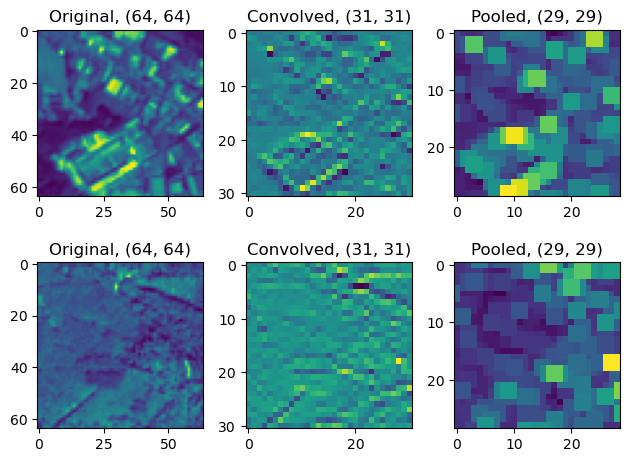

In [91]:
# Sobel operator For Ix(x,y)
sobel_x = torch.tensor([[-1,-2,-1],
                        [0,0,0],
                        [1,2,1]], dtype=torch.float32)
# sobel_x = torch.tensor([[0,1,2],
#                         [-1,0,1],
#                         [-2,-1,0]], dtype=torch.float32)

sobel_x_kernel = sobel_x.unsqueeze(0).unsqueeze(0)
print(f'the sobel_x_kernel dtype = {sobel_x_kernel.dtype}, its shape = {sobel_x_kernel.shape}')

# a. Bedenk en maak zelf een 2d convolution filter
convulutionFilter = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, bias=False)
convulutionFilter.weight.data = sobel_x_kernel

# b. Bedenk en maak zelf een 2d pooling filter
poolingFilter = nn.MaxPool2d(kernel_size=3, stride=1, padding=0)

# c. Pas nu de convolutie toe op 'Industrial_1.jpg'
industrial2 = convulutionFilter(industrial1)

# d. Pas vervolgens een pooling toe op de uitkomst van c.
industrial3 = poolingFilter(industrial2)

# e. Doe hetzelfde voor de afbeelding 'Forrest_1.jpg'
forest2 = convulutionFilter(forest1)
forest3 = poolingFilter(forest2)

# plot all images next to each other
showImages(industrial1,industrial2,industrial3,forest1,forest2,forest3)

### Reflectie

- Verschilt de uitkomst veel van de combinatie veel met convolutie en pooling?
- En zijn de afbeeldingen 'Industrial_1.jpg' en 'Forrest_1.jpg' beter te onderscheiden?

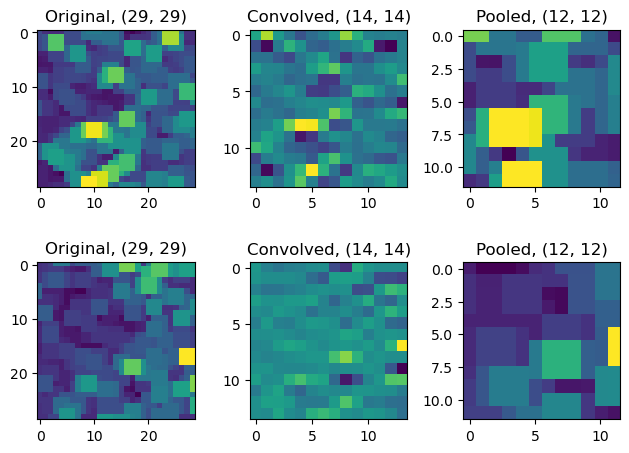

In [92]:
# Extra: bereid de combinatie uit met nog een extra convolutie en pooling laag
industrial4 = convulutionFilter(industrial3)
industrial5 = poolingFilter(industrial4)

forest4 = convulutionFilter(forest3)
forest5 = poolingFilter(forest4)


# plot all images next to each other
showImages(industrial3,industrial4,industrial5,forest3,forest4,forest5)

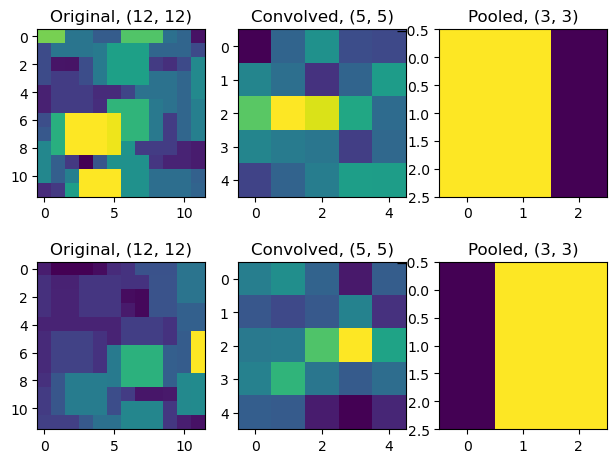

In [93]:
# Extra: bereid de combinatie uit met nog een extra convolutie en pooling laag
industrial6 = convulutionFilter(industrial5)
industrial7 = poolingFilter(industrial6)

forest6 = convulutionFilter(forest5)
forest7 = poolingFilter(forest6)


# plot all images next to each other
showImages(industrial5,industrial6,industrial7,forest5,forest6,forest7)

### Reflectie

Heeft een extra laag veel invloed op de onderscheidbaarheid van de afbeeldingen?

I have repeated the convulution/ pooling two additional times, eventually the immage gets verry blurry. switching the stride from 1 to 2 schrinks it tremendously. 
also makes it uninteligable for my human brain.

### Opdracht 5: dataset prepareren

Om het neurale netwerk te trainen moeten we de dataset opsplitsen in labels (Y, de categoriën) en input afbeeldingen (X).

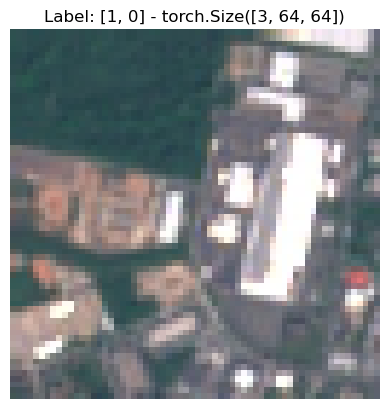

tensor([[[ 46.,  48.,  48.,  ..., 223., 158., 102.],
         [ 45.,  48.,  48.,  ..., 226., 158., 102.],
         [ 44.,  45.,  47.,  ..., 216., 141.,  98.],
         ...,
         [ 85.,  86.,  95.,  ...,  89.,  94.,  95.],
         [ 66.,  66.,  71.,  ...,  80.,  89.,  93.],
         [ 66.,  66.,  73.,  ...,  85.,  91.,  92.]],

        [[ 80.,  79.,  77.,  ..., 221., 156., 103.],
         [ 81.,  79.,  77.,  ..., 220., 156., 104.],
         [ 80.,  79.,  78.,  ..., 206., 140., 102.],
         ...,
         [ 93.,  93.,  98.,  ...,  98., 101.,  97.],
         [ 81.,  81.,  81.,  ...,  91.,  98.,  97.],
         [ 86.,  85.,  87.,  ...,  93., 100.,  98.]],

        [[ 79.,  81.,  81.,  ..., 224., 169., 121.],
         [ 79.,  81.,  81.,  ..., 224., 167., 119.],
         [ 78.,  80.,  80.,  ..., 214., 148., 113.],
         ...,
         [104., 103., 105.,  ..., 105., 109., 109.],
         [ 84.,  88.,  90.,  ...,  95., 105., 109.],
         [ 84.,  89.,  96.,  ...,  95., 105., 110.]]]

In [98]:
# a. Denk nog eens terug aan hoe we kruisjes van rondjes van elkaar konden onderscheiden

#    - Hoe representeerden we de labels?  # [0,1] en [1,0]
#    - Hoe representeerden we de kruisjes en de rondjes?  # [[1,1,1],[1,0,1],[1,1,1]] en [[1,0,1],[0,1,0],[1,0,1] als basis rondje en kruisje.
#    - Hoe combineerden we dit tot een dataset?  # als extra waarde in de array. 

# b. Hoe kunnen we de labels 'Industrials' en 'Forrest' dus representeren? [0] is industrial and [1] is forest 

# c. Vorm nu een dataset voor 'Industrials' en 'Forrest'

class LandDataset(Dataset):
    def __init__(self, directory, Label):
        self.data = self.load_images(directory)
        self.labels = [Label] * len(self.data)  # Assigning the same label (0) to all industrial images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        return image, label

    
    def load_images(self, directory):
        image_files = listdir(directory)
        data = []
        for file in image_files:
            image_path = path.join(directory, file)
            image = torchvision.io.read_image(image_path, mode=ImageReadMode.UNCHANGED).to(torch.float32)
            data.append(image)
        return data


forestDataset = LandDataset(forestDirectory, [0,1])
industrialDataset = LandDataset(industrialDirectory, [1,0])



# d. Extra: implementeer bovenstaande via een Dataset en DataLoader class

# Concatenate the datasets into a single dataset
dataset = torch.utils.data.ConcatDataset([forestDataset, industrialDataset])

ShowDatasetImage(dataset, index='random')

# create a data loader
# torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=None, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None, generator=None, *, prefetch_factor=None, persistent_workers=False, pin_memory_device='')[SOURCE]¶
LandDataLoader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True)

#           (zie https://pytorch.org/docs/stable/data.html voor verdere details)

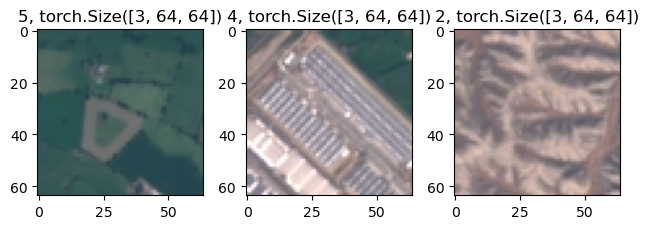

In [157]:
# alternative way to imort the data and a data loader

# Define the path to the root directory of your image dataset
data_dir = '../../pics/2750'

# Define the transformation to apply to each image
transform = T.Compose([
    T.ToTensor(),
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization if needed as shown in blog
])

# Create the ImageFolder dataset
dataset = ImageFolder(data_dir, transform=transform)



# Assuming you have a dataset named 'dataset' with features and labels
dataset_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Set the seed for the generator
seed = 42
generator = torch.Generator().manual_seed(seed)

# Calculate the number of samples for each split
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)


# Define the batch size for the DataLoader
batch_size = 32

# Create the DataLoader to load the dataset in batches
train_d = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_d = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_d = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Show the 1st img in the dataset
show_batch(train_d, test_d,val_d)


### Opdracht 6: CNN ontwerpen

We kunnen een convolutional neural net opbouwen met convolutie, pooling en fully connected lagen. Hieronder definiëren we een topologie om een afbeeldingen van 32 x 32 te onderscheiden.

De topologie is gebaseerd op de blog post 'A simple CNN with Pytorch'. Dus zie het artikel voor extra details.

In [52]:
#-------------------------------------------------------

class CNN(nn.Module):
    
    #-------------------------------------------------------
    
    def __init__(self):
        
        # Because we inherit from Module base class
        super().__init__()
        
        # RGB input, 6 filters, kernel of 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Filter is 2 x 2 with a stride of 2 (defined once, used two times)
        self.pool = nn.MaxPool2d(2, 2)
        
        # in_channels = 6 because self.conv1 output has 6 channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layer matched on output of conv2 layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # We only have 2 labels
        self.fc3 = nn.Linear(84, 2)
        
    #-------------------------------------------------------
        
    def forward(self, x):
        
        # Convolution with relu layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # To match the output of the conv2 layer onto the first fully connected layer
        # Like reshape() but makes no copy (reuses underlaying data)
        x = x.view(-1, 16 * 13 * 13)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # No activation on final layer 
        return self.fc3(x)

#-------------------------------------------------------

### Opdracht 7: CNN trainen

Het trainen van een CNN is identiek aan het trainen van een fully connected (a.k.a. dense) netwerk.

In [36]:
# a. Ga voor jezelf na welke stappen een typisch trainingsproces bevat
 # 1. Data verzamelen
    # 2. Data voorbereiden
    # 3. Data inladen
    # 4. Model maken
    # 5. Model shape W & B opslaan tijdens het trainen
    # 5. Model trainen
    # 6. Model testen
    # 7. Model verbeteren
    # 8. Model beste model selecteren





# b. Bekijk de blog post 'A simple CNN in Python' en zet de training op

model = CNN()   # Create the model
criterion = nn.CrossEntropyLoss()   # Define the loss function  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# c. Het voorbeeld bevat geen validatie tijdens de trainingsstap (epoch)

#    - Bekijk het Notebook met de de postcode FastScan
#      en bereid de training uit met validatie in de trainingsloop

### Opdracht 8: dropout toevoegen

Om het netwerk effectiever te trainen wordt dropout toegepast.

PyTorch maakt het toevoegen van dropout makkelijk.

In [37]:
# a. Bekijk het artikel Using Dropout Regularization in PyTorch Models (zie sources)

# b. Pas nu dropout toe op een hidden layer van je model

# c. Hertrain je model

#    - Let er op dat je je model evalueert in eval() mode
#    - Heeft de dropout invloed op de accuracy van je model?

### Reflectie

- Wat gebeurt er als de dropout groot is (bijvoobeeld 0.9)?

### Bronnen

[EuroSAT project](https://github.com/phelber/eurosat)

[Pytorch Neural Nets](https://pytorch.org/docs/stable/nn.html)

[Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))

[A simple CNN with Pytorch](https://tomroth.com.au/pytorch-cnn)

[A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

[Using Dropout Regularization in PyTorch Models](https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models)